In [25]:
# copyright ############################### #
# This file is part of the Xtrack Package.  #
# Copyright (c) CERN, 2021.                 #
# ######################################### #


import ducktrack as dtk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from tqdm import tqdm

import xtrack as xt
import xobjects as xo
import xpart as xp


beta_rel = 0.305
#beta_rel = 0.106

gamma = 1.050
#gamma = 1.006


current=2.4
length = 1.5 # m cooler length
r_beam=25*1e-3

mass0=938.27208816*1e6 #ev/c^2

T_perp = 100e-3 # <E> [eV] = kb*T
T_l =  1e-3 # <E> [eV]
B = 0.060 # T for AD
B_ratio=1e-10



c=299792458.0

p0c = mass0*beta_rel*gamma #eV/c



circumference = 182.43280000000 #m
T = circumference/(c*beta_rel)
s_per_turn = T


beta_x=10 
beta_y=4

#disp_x=0.12

                                        


In [26]:
#dispersion and space charge parabola

dtk_cooler = dtk.elements.ElectronCooler(current=current,length=length,r_beam=r_beam,
                                         T_perp=T_perp,T_l=T_l,
                                         B=B,B_ratio=B_ratio,
                                         Neutralisation_space_charge=1,Neutralisation_rotation=0)      


r=np.arange(start=-50*1e-2, stop=50*1e-2, step=1e-3)

#beta_diff=dtk_cooler.radial_velocity_dependence(gamma,r,current,beta_rel,r_beam)   
# beta2=beta_diff+beta_rel

dE_E = (1.2e-4*current/(beta_rel**3))*(r/r_beam)**2


E = dtk_cooler.beta_to_kinetic_energy(beta_rel, dtk_cooler.me_ev)# + Pb_m0_MeV_c2 #Mev/c^2
E_diff = dE_E*E
E_tot = E + E_diff
beta2=dtk_cooler.kinetic_energy_to_beta(E_tot, dtk_cooler.me_ev)
#beta_ratio = beta2/beta
beta_diff = beta2-beta_rel

p0 = beta_rel*dtk_cooler.me_ev*gamma
p2 = beta2*dtk_cooler.me_ev*gamma

dp_p=(p2-p0)/p0                                         

Parameters: $I=2.4 A, B=0.060 T, \beta_x=10 m,\beta_y=4,D_x=0.12 m T_\perp=100meV,T_\parallel=1meV,\epsilon_{x}=35*1e-6,\epsilon_{y}=35*1e-6,dp/p=1e-3$

In [27]:
cooling_time=[]
num_particles=1

disp_values=np.linspace(1, 10, num=5)

for disp in tqdm(disp_values):
     
    disp_x=disp

    arc=xt.LinearTransferMatrix(Q_x=5.44, Q_y=5.42,
                                beta_x_0=beta_x, beta_x_1=beta_x,
                                beta_y_0=beta_y,  beta_y_1=beta_y,
                                alpha_x_0=0,   alpha_x_1=0,
                                alpha_y_0=0,   alpha_y_1=0,
                                disp_x_0=0,disp_x_1=disp_x,
                                disp_y_0=0,    disp_y_1=0,
                                beta_s=1*1e40,
                                Q_s=0,
                                chroma_x=0.0, chroma_y=0)

    delta_single=2e-3

    dtk_particle = xp.Particles(
            
            mass0=mass0,
            p0c=p0c,
            x=disp_x*delta_single,
            px=0,
            y=0,
            py=0,
            delta=delta_single,
            zeta=0)


    dtk_cooler = xt.ElectronCooler(current=current,length=length,r_beam=r_beam,
                                            T_perp=T_perp,T_l=T_l,
                                            B=B,B_ratio=1e-4,
                                            Neutralisation_space_charge=1)

        

    num_turns=int(1*1e7)
    step=int(num_turns/100)

    # initialize arrays
    x, px, delta, action_x = [], [], [], []
    
    # loop over turns
    for i in tqdm(range(num_turns)):
        if i % step == 0 or i==0:
            #x.append(dtk_particle.x)
            #px.append(dtk_particle.px)
            #delta.append(dtk_particle.delta)
            
            # calculate action in horizontal plane
            action_x_temp = (dtk_particle.x**2/beta_x + beta_x*dtk_particle.px**2)
            action_x.append(action_x_temp)
        
            
            if dtk_particle.delta < 0.1* delta_single:
                    cooling_time.append(i*s_per_turn)
                    break

        
        # track particle
        arc.track(dtk_particle)
        dtk_cooler.track(dtk_particle)
    
   


100%|██████████| 5/5 [08:40<00:00, 104.01s/it]


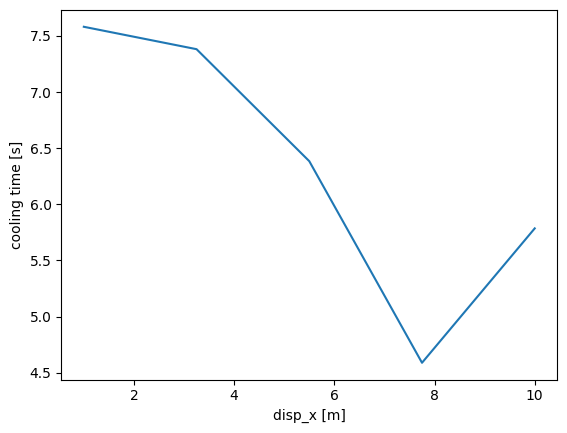

In [28]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure()
plt.plot(disp_values,cooling_time)
plt.xlabel('disp_x [m]')
plt.ylabel('cooling time [s]')
plt.title(f'delta')
plt.show()
